### Installation

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("chromVAR", version = "3.8")
# BiocManager::install("motifmatchr", version = "3.8")
# BiocManager::install("BSgenome.Hsapiens.UCSC.hg19", version = "3.8")
# BiocManager::install("JASPAR2016", version = "3.8")

###  Import packages

In [2]:
library(chromVAR)
library(motifmatchr)
library(Matrix)
library(SummarizedExperiment)
library(BiocParallel)
library('JASPAR2016')
library(BSgenome.Hsapiens.UCSC.hg19)


Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, r

In [3]:
packageVersion("chromVAR")

[1] ‘1.4.1’

In [4]:
register(MulticoreParam(10))

### Obtain Feature Matrix

In [5]:
start_time <- Sys.time()

In [6]:
set.seed(2019)

In [7]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [8]:
head(metadata)

,label
AAACGAAAGCGCAATG-1,2
AAACGAAAGGGTATCG-1,6
AAACGAAAGTAACATG-1,1
AAACGAAAGTTACACC-1,4
AAACGAACAGAGATGC-1,5
AAACGAACATGCTATG-1,6


In [9]:
peakfile <- "../../input/atac_v1_pbmc_5k_peaks.bed"
peaks <- getPeaks(peakfile, sort_peaks = TRUE)

Warning message in getPeaks(peakfile, sort_peaks = TRUE):
“Peaks are not equal width!Use resize(peaks, width = x, fix = "center") to make peaks equal in size, where x is the desired size of the peaks)”

`width=500` will cause the error: Error in loadFUN(x, seqname, ranges): trying to load regions beyond the boundaries of non-circular sequence "chr17"

In [10]:
peaks <- resize(peaks, width = 450, fix = "center")

In [11]:
bamfile <- list.files(path = "../../input/sc-bams_nodup/", pattern = "\\.bam$")

In [12]:
length(bamfile)

[1] 5335

In [13]:
head(bamfile)

[1] "atac_v1_pbmc_5k_possorted_bam.AAACGAAAGCGCAATG-1.dedup.st.bam"
[2] "atac_v1_pbmc_5k_possorted_bam.AAACGAAAGGGTATCG-1.dedup.st.bam"
[3] "atac_v1_pbmc_5k_possorted_bam.AAACGAAAGTAACATG-1.dedup.st.bam"
[4] "atac_v1_pbmc_5k_possorted_bam.AAACGAAAGTTACACC-1.dedup.st.bam"
[5] "atac_v1_pbmc_5k_possorted_bam.AAACGAACAGAGATGC-1.dedup.st.bam"
[6] "atac_v1_pbmc_5k_possorted_bam.AAACGAACATGCTATG-1.dedup.st.bam"

In [14]:
cellnames <- sapply(strsplit(bamfile,'.',fixed = TRUE), "[[", 2)

In [15]:
sum(cellnames == rownames(metadata))

[1] 5335

In [16]:
# ix = match(rownames(metadata),cellnames)
# bamfile = bamfile[ix]
# cellnames = cellnames[ix]

In [17]:
# sum(cellnames == rownames(metadata))

In [18]:
head(paste0("../../input/sc-bams_nodup/",bamfile))

[1] "../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAAGCGCAATG-1.dedup.st.bam"
[2] "../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAAGGGTATCG-1.dedup.st.bam"
[3] "../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAAGTAACATG-1.dedup.st.bam"
[4] "../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAAGTTACACC-1.dedup.st.bam"
[5] "../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAACAGAGATGC-1.dedup.st.bam"
[6] "../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAACATGCTATG-1.dedup.st.bam"

In [ ]:
fragment_counts <- getCounts(paste0("../../input/sc-bams_nodup/",bamfile), 
                             peaks, 
                             paired = TRUE, 
                             by_rg = FALSE, 
                             format = "bam", 
                             colData = data.frame(cellid = cellnames,
                                                  label = metadata$label))

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAAGCGCAATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAAGGGTATCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAAGTAACATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAAGTTACACC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAACAGAGATGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAACATGCTATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAGTGCATCAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAGTGGACGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAACGAAGTGGCCTCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAATGCCAGTACGCGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAATGCCCACAAACAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAATGCCCACTCCCAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAATGCCCATCGCTAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAATGCCGTACGAGAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAATGCCGTCACAGGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAATGCCGTCTGGATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AAATGCCTCACTAGGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACAAAGAGACCCATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACCTGACAATTGGCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACCTGACATAGACGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACCTGATCGCACAAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACCTGATCTCTTCCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACCTTTAGAATACTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACCTTTAGCCTCGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACCTTTAGTCTCGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACCTTTAGTCTGTGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACCTTTCAAGGCGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACTGTGGTCTCGGGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACTGTGGTGGATTTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACTGTGTCCTCCATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACTTGGCAAATGTCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACTTGGCAAGCCCTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACTTGGCAAGGATGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACTTGGCAAGTTCGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACTTGGCAATGCACT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AACTTGGCAATTCGTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AATGGAAGTCGCTAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AATGGAAGTCTCTGGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AATGGAATCGTCGCAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AATGGAATCTATCTAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AATGGAATCTGTTGCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AATGGCTAGGATATCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AATGGCTAGTCCCTCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AATGGCTAGTCGCCTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AATGGCTCACGCCGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACAGACTAGAGGAAGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACAGACTAGCACGTAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACAGACTCATCGTGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACAGACTGTGCAGACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACAGACTGTGCTTCCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACAGACTGTTTCTCTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACAGACTTCACCACAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACAGACTTCACCCGGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACAGCGCAGAGGCAGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACCCAAACATTGTTCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACCCAAAGTCGCTAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACCCAAAGTGAGTTGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACCCAAATCCTCATTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACCCAAATCCTTACGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACCCAAATCGTCAACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACCGAATAGAGAGGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACCGAATAGTATGGGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACCGAATCAACGGGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTAACGCAAGCTTTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTAACGCAGATGGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTAACGCAGCAACGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTAACGCAGCACATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTAACGCAGCGTCGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTAACGGTCCTCAGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTAACGGTTATGCAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTAACGGTTGGAGGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTAACGGTTTAGAAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTGCAAGTTTGGATC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTGCAATCGTGGGTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTGCGGCAATGCACT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTGCGGGTCATAAGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTGCGGGTTATGCAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTGCGGTCCCGATTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTGTCCAGGACTTTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTGTCCAGTAACACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ACTGTCCAGTAACTCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCCCGAAGAAAGGGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCCCGAAGTAATGTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCCCGAAGTATGGGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCCCGAAGTCGAAAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCCCGACACTAGGAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCCCGAGTATTCGAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCCCGAGTCTGGTCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCCCGATCCAGAGAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCCCGATCTGAACGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCGTGCTCGATGCAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCGTGCTCGGTTGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCTATGAGACGCCAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCTATGAGAGTTCGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCTATGAGCTTCAAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCTATGGTCGAGAAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCTATGGTGATAAGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCTATGTCCAACAAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGCTATGTCCATATCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGGCCTGTCTTACTCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGGCGAAAGCACGTAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGGCGAAAGCAGAGCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGGCGAAAGCTAGTTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGGCGAAAGGGTGTTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGGCGAAAGTAGTCGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGGCGAAAGTCCCTCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGGCGAACAAGGCTTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGGCGAACAGGTCTGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGTGCGCGTGTCCAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGTGCGCGTTCTTATC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGTGCGCTCCAACCTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGTGCGCTCGGCATAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGTGTACAGAAGCCTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGTGTACAGCCGCTGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGTGTACAGTTCTCCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGTGTACCATTTGTTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.AGTGTACGTAATGCCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATCCAGACATTGCGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATCCAGAGTAACATAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATCCAGAGTACCCATA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATCCAGAGTGGCGCTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATCCAGAGTGGGTAGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATCCAGAGTTAGGAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATCCAGAGTTTGATCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATCCAGATCCAACAAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATCCAGATCCAGGGAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATGTACGAGTATGCTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATGTACGAGTTGCCGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATGTACGCAATAGCGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATGTACGCACAGATGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATGTACGCATAGATAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATGTACGGTGTGAGGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATGTACGGTTTGATCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATGTACGTCCGTGCGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATGTACGTCTTCTTCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATTGTCTTCGACTGGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATTGTCTTCTGTCGGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATTGTGGAGACGAAAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATTGTGGAGCGCCTAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATTGTGGAGGCAGTGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATTGTGGCAGGCACAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATTGTGGCATGGTAAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATTGTGGGTCCAAGTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.ATTGTGGGTCGTAGTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAAGCTAGTAGTGATA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAAGCTAGTGCATTCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAAGCTAGTTACTACG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAAGCTATCGCGATGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAAGCTATCTTCCGTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAAGGCCAGACAACGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAAGGCCAGCAACTGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAAGGCCAGTTAGCAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAAGGCCAGTTGCGCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CACGTTCCAGGAGCAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CACGTTCCATGTATCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CACGTTCGTAGCCATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CACGTTCGTCTGAGCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CACGTTCGTTCCTATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CACGTTCTCCGGACTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CACGTTCTCGTATAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CACTAAGAGGAGTAGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CACTAAGAGTTACCAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAGGATTCAGGCATCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAGGATTCAGGTGTGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAGGATTGTAGACACG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAGGATTGTCCGGTAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAGGATTGTCCTTATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAGGATTTCCAGAGAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAGGGCTAGAGCCTGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAGGGCTAGCGCAATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CAGGGCTAGGGCGAAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CATTCCGAGATGCGAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CATTCCGAGCGAGCTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CATTCCGAGGCGATTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CATTCCGAGGTTGTTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CATTCCGCACGTTAGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CATTCCGCACTGTAAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CATTCCGCAGTAGTTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CATTCCGCATCCCTTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CATTCCGGTATGAAGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCAGATAAGGTAAGCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCAGATAAGGTGAACC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCAGATAAGTTGACAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCAGATACAATACTGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCAGATACATGATTGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCAGATAGTCTGGTCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCAGATAGTTAACCAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCAGATATCGCGCCAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCATACCAGCGCATTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCCTCTCTCATCGCAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCCTCTCTCCTTACGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCCTGATAGCGTCTGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCCTGATAGTGCTCGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCCTGATCAAAGCATA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCCTGATCATCCATAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCCTGATGTTTCTACT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCCTGATGTTTGTCTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCCTGATTCCGTTTCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCGTGAGTCGGCATAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCGTGAGTCTCTGCAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCGTGAGTCTGAGTAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCGTGAGTCTTCACTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTAAAGCAAGGACCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTAAAGCAAGTCTCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTAAAGCACAGAAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTAAAGGTCCGTGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTAAAGGTTACCCAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTTGCATCAGGATCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTTGCATCGTCGCAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTTGGTAGACCCATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTTGGTAGTAACATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTTGGTAGTTTGGAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTTGGTCACTGTCGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTTGGTCAGCGTCGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTTGGTGTGCACCCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CCTTGGTGTTTGTGAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGCGCAACATGCACTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGCGCAAGTAGAAAGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGCGCAAGTCAGCAAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGCGCAAGTCGCTAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGCGCAAGTGCGTAGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGCGCAAGTTCTTTCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGCGCAATCCATCATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGCGCAATCGAACCGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGCGCAATCGCTTGAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGGTGCACAAGCCCTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGGTGCACAATGGTAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGGTGCACACATCATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGGTGCACAGACCTGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGGTGCACAGGATAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGGTGCACATGCACTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGGTGCAGTATGTTCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGGTGCATCAAAGTAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CGGTGCATCAGGATCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTAACTTTCCCACTTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTAACTTTCTGAGTAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTACAGAAGACCAATA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTACAGAAGAGTCCGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTACAGAAGCAGGAGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTACAGAAGGCTTCGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTACAGACAAGAGATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTACAGACACGTACAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTACAGACAGGTTATC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCAGAAGTAGCGGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCAGAAGTTGCAGAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCAGAATCCAACGCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCAGCTAGTCGTACT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCAGCTAGTTCAAGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCAGCTCACGTGAAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCAGCTCAGATACAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCAGCTCATCGGCTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCAGCTCATGGCCTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCTCAGTCGTTGTAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCTCAGTCTGAACGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCTCGAAGACTAGCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCTCGAAGGGTAATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCTCGAAGTCCGGAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCTCGACAACTTGGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCTCGACAAGTGGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCTCGACACTCAGCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTCTCGACAGCGCGTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTGTATTCAAATAGTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTGTATTCAAGGGTAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTGTATTCAATAGCGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTGTATTCACGATATC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTGTATTCACTCAGCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTGTATTCATTCTTTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTGTATTGTCGGCTGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTGTATTGTGCTTCCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTGTATTTCATTCTTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTTGCTGCACCTATTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTTGCTGCAGAGTCGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTTGCTGCAGGCATCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTTGCTGCATGGGACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTTGCTGGTCATGAGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTTGCTGGTTCCTGTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTTGTCGAGACGAAAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTTGTCGAGAGGCGGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.CTTGTCGAGCCATTCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAACCTACATCGCCTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAACCTAGTATCGCGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAACCTAGTCCGAGCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAACCTAGTCCGTCGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAACCTAGTTGAATAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAACCTATCATCGCAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAACCTATCCACGCTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAACCTATCCGGCTGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAACCTATCGACTATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GACCGACTCAGGAATA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GACCGACTCCGATGCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GACCTTCCAGTTGCAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GACCTTCGTAGCGTTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GACCTTCGTGTACGCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GACCTTCTCAATTCCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GACCTTCTCCATACGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GACTAACAGCAACGGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GACTAACCAGAACTTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAGCATTCACACATTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAGCATTCAGGCAGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAGCATTGTAACACTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAGCATTGTCAGAAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAGCATTTCTTGTACT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAGCGCTAGAGGAACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAGCGCTAGATGAGGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAGCGCTAGCCATGGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GAGCGCTAGCGGACTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GATCATGGTGGCATAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GATCATGGTTACGGAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GATCATGGTTCTCGAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GATCATGGTTCTGAAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GATCATGTCAGGAATA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GATCATGTCTCCTTGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GATCATGTCTGTCGGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GATCGTAAGATGGGAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GATCGTAAGCCTGTAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAAAGGCATTCTTTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAAAGGTCAAATGGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAAAGGTCCAGTTAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAAAGGTCGTGGGTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAAAGGTCTATGAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAAAGGTCTCTATTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAAAGGTCTGTTGCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAACCGAGCTATCCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAACCGCAAGAAACT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAGCCATCAGAACGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAGCTGAGACAGTGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAGCTGAGATGTTGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAGCTGAGATTCCGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAGCTGAGCAGTAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAGCTGAGCTGAATA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAGCTGAGTATACGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAGCTGCAAACAGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCAGCTGCAAATGCTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCCCAGACATCGACCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCCCAGACATCGGCCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCCCAGACATTTGGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCCCAGAGTACAAGCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCCCAGAGTACCGGCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCCCAGAGTCCAGACC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCCCAGAGTGTCCAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCCCAGAGTTTCCGGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCCCAGATCACTGGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCGATTATCGGCATAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCGCATGAGCGTTGCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCGCATGCAAGTAACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCGCATGCATGCGACC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCGCATGTCCGTCAAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCGCATGTCGATGTAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCGCATGTCTCTCAAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCGCATGTCTGATCCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCGCATGTCTTACTCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTCACTAGGTCTTGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTCACTAGTCAACTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTCACTAGTCTTAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTCACTAGTTACCAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTCACTAGTTAGCAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTCACTCAAATTCCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTCACTCAAGCAGGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTCACTCAGGGTACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTCACTCATCTCACC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTGTTCCACGACGAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTGTTCCACGCGCAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTGTTCCACGTTACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTGTTCCATACTGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTGTTCCATATACGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTGTTCCATTACACG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTGTTCCATTCACCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTGTTCCATTTAGGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GCTGTTCGTGGACGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGAATCTTCTCGTGAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGACACCAGACAACGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGACACCAGGCTGGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGACACCCATATTGGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGACACCCATGGCCTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGACACCCATGGTATC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGACACCGTCCATTGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGACACCGTTGAAGCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGACACCTCAAGGCAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGCATTAAGCATTGGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGCATTAAGCGTAGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGCATTAAGTAGGTCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGCATTACAAGGCGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGCATTACACACACCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGCATTACACTCAAGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGCATTACATCATGTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGCATTAGTAGACGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGCATTAGTCGCGCTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGGTGTCTCCAGGTCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGGTGTCTCCCGGGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGGTGTCTCTTACGGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGGTTATAGGGAGATA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGGTTATAGGGTCTGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGGTTATCAGATGGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGGTTATGTCAGACGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGGTTATGTGTTGTTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGGTTATTCGCCTTAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGTGTCGTCACTAGGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGTGTCGTCGGTTCCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGTTGCGAGAACAGGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGTTGCGAGTTCCCGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGTTGCGCAACTGCGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGTTGCGCATGTGGGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGTTGCGGTCAACTAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGTTGCGGTGATAACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GGTTGCGTCAATTGGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTCACCTCAAGCAGGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTCACCTGTATGCTAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTCACCTGTATGGTTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTCACCTGTATTGTGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTCACCTGTCTCTGGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTCACCTGTTAACCAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTCACGGAGACCTATC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTCACGGAGCTCGGCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTCACGGCAGCAATGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGACATCAGCAACAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGACATCAGGCAAGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGACATCATCATGTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGACATCATGCGCTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGACATGTGAGGTCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGACATGTTTAGAAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGACATTCTTAACGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGATCAAGGACCGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGATCACAAGCAACG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGTCAATCGTCAACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGTCAATCTCCAACC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGTCAATCTCTTCTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGTCCTAGTCGAGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGTCCTCAAACCCTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGTCCTCAAGCGTCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGTCCTCACACATGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGTCCTCACATATCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTGTCCTCAGTGGTCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTTGGGCCACGCGACT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTTGGGCGTAACTCCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTTGGTAAGCAAGGTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTTGGTAAGCATTGGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTTGGTACAAAGAAGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTTGGTACACAGCCAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTTGGTACACATCATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTTGGTAGTACTATGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.GTTGGTAGTCGCTAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAAGTGCAGTATGGGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAAGTGCGTAGTAACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAAGTGCGTGAATGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAAGTGCGTGGAAGCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAAGTGCTCATCGCAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAAGTGCTCTATAGGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAAGTGCTCTCATCCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAAGTGCTCTTGGCCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAATCGGAGAGTGGAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACCCTGGTCCGTAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACCCTGGTGCATTGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACCCTGGTGTTGGTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACCTATAGCATGTGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACCTATAGCGTAGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACCTATAGTTGCGCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACCTATCAATCACTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACCTATGTAATGTGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACCTATGTACGGTTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACGGATCACATTCTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACGGATCACTCAAGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACGGATCAGAGTCGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACGGATCAGGCAAGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACGGATCAGTCAGAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACGGATTCCAGAATC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACTAGGAGTAGGTCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACTAGGCAACATAAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TACTAGGCATTACACG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAGCCCTGTATGGGTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAGCCCTTCGGTACTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAGCCCTTCTCGGCGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAGCCGGAGTAGTGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAGCCGGAGTCACGCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAGCCGGAGTGTCGCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAGCCGGCAAGTTCGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAGCCGGGTAAACGGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TAGCCGGGTAGACACG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TATCGAGTCGCGGCAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TATCGAGTCGTGGCGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TATCTGTAGACAGCTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TATCTGTAGCCTATAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TATCTGTCAAACGTTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TATCTGTCAGCAACCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TATCTGTGTGAATCGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TATCTGTGTGCAAAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TATCTGTGTGCGTTTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCAAGGTGTACGCCCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCAAGGTGTGATGTGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCAAGGTGTGTGTGTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCAAGGTGTTAGCTCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCAAGGTGTTCCGGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCAAGGTTCAAAGTAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCAAGGTTCACCACAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCAAGGTTCCGTACGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCAAGGTTCCTCCTGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCACCTGGTTGAATAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCACCTGTCCAGTTAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCACCTGTCCATTGTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCACCTGTCCCAGTAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCACCTGTCGGTCAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCACTCGAGAAATACC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCACTCGAGTAACTCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCACTCGAGTTCAAGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCACTCGCATTAGCCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCCAGAAAGGCATGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCCAGAAAGGTCGGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCCAGAAAGTAGGTCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCCAGAAAGTTACCAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCCAGAACACCACGAC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCCAGAACAGGCAGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCCAGAACATTACTTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCCAGAACATTGATGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCCAGAAGTAAGTCTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCGCCTACAATGGTCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCGCCTACACCTGTGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCGCCTACACGTTGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCGCCTACACTACACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCGCCTAGTAAGTGCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCGCCTAGTAGCTGTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCGCCTAGTCACCCGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCGCCTAGTGGACTGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TCGCCTAGTTGGCGAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGACAACGTCGAGGAT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGACAACGTCTGTTGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGACAACGTGGCATAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGACAACTCATCGCTC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGACAACTCCTCCATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGACTCCCAAGTGGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGACTCCGTACTTCGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGACTCCGTTACCACA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGACTCCTCAAACCCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCATTTAGGCAATTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCATTTAGTAGGTCG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCATTTCACCGAATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCATTTCACTCAAGT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCATTTGTAATGCAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCATTTGTATCTGCA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCATTTGTCTCTGGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCATTTGTGCTGTGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCATTTTCCTCATTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCTTCGTCAATCGTG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCTTCGTCACGTCAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCTTCGTCGACTATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCTTCGTCGGTGATT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCTTCGTCTGCCGAG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCTTTAAGCGCAATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCTTTAAGGTACTCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCTTTACACTGTCGG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGCTTTACAGCAGGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGGTCAACAATCCATG-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGGTCAACAATGTGCT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGGTCAACAGGTGGTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGGTCAACATGCACTA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGGTCAAGTCAACGGA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGGTCAAGTCACAGTT-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGGTCAAGTCGCTAGC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGGTCAAGTTCCCAAA-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc_5k_possorted_bam.TGGTCAATCACATCCC-1.dedup.st.bam
Reading in file: ../../input/sc-bams_nodup/atac_v1_pbmc

In [38]:
fragment_counts

class: RangedSummarizedExperiment 
dim: 97998 5335 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(1): bias
colnames(5335):
  atac_v1_pbmc_5k_possorted_bam.AAACGAAAGCGCAATG-1.dedup.st.bam
  atac_v1_pbmc_5k_possorted_bam.AAACGAAAGGGTATCG-1.dedup.st.bam ...
  atac_v1_pbmc_5k_possorted_bam.TTTGTGTGTCTGCGCA-1.dedup.st.bam
  atac_v1_pbmc_5k_possorted_bam.TTTGTGTTCAACTTGG-1.dedup.st.bam
colData names(3): cellid label depth

In [ ]:
fragment_counts <- addGCBias(fragment_counts, genome = BSgenome.Hsapiens.UCSC.hg19)

In [ ]:
head(rowData(fragment_counts))

In [ ]:
counts_filtered <- filterPeaks(fragment_counts, non_overlapping = TRUE)

In [ ]:
bg <- getBackgroundPeaks(counts_filtered)
# Potentially save the bg object
saveRDS(bg, file = "background_peaks_kmers.rds")

In [ ]:
kmer_ix <- matchKmers(6, counts_filtered, genome = BSgenome.Hsapiens.UCSC.hg19)

In [ ]:
dev <- computeDeviations(object = counts_filtered, annotations = kmer_ix,
                         background_peaks = bg)

In [ ]:
end_time <- Sys.time()

In [39]:
end_time - start_time

Time difference of 23.74807 mins

In [ ]:
df_zscores = dev@assays[[1]]

In [40]:
dim(df_zscores)
df_zscores[1:5,1:5]

[1] 2080 5335

,atac_v1_pbmc_5k_possorted_bam.AAACGAAAGCGCAATG-1.dedup.st.bam,atac_v1_pbmc_5k_possorted_bam.AAACGAAAGGGTATCG-1.dedup.st.bam,atac_v1_pbmc_5k_possorted_bam.AAACGAAAGTAACATG-1.dedup.st.bam,atac_v1_pbmc_5k_possorted_bam.AAACGAAAGTTACACC-1.dedup.st.bam,atac_v1_pbmc_5k_possorted_bam.AAACGAACAGAGATGC-1.dedup.st.bam
AAAAAA,-0.009649360,-0.006881943,0.03849852,-0.010449249,-0.05089478
AAAAAC,-0.029219680,-0.025996890,0.01418720,0.025996115,-0.09630572
AAAAAG,0.007373033,-0.026305809,0.03505194,-0.014190822,-0.01272849
AAAAAT,-0.032478208,-0.004504465,0.02055424,0.013731533,-0.05969611
AAAACA,0.008950168,0.002657968,0.02364697,-0.003864243,-0.06232181


In [41]:
sum(sapply(strsplit(colnames(df_zscores),'.',fixed = TRUE), "[[", 2) == rownames(metadata))

[1] 5335

In [42]:
colnames(df_zscores) = rownames(metadata)
df_zscores[1:5,1:5]

,AAACGAAAGCGCAATG-1,AAACGAAAGGGTATCG-1,AAACGAAAGTAACATG-1,AAACGAAAGTTACACC-1,AAACGAACAGAGATGC-1
AAAAAA,-0.009649360,-0.006881943,0.03849852,-0.010449249,-0.05089478
AAAAAC,-0.029219680,-0.025996890,0.01418720,0.025996115,-0.09630572
AAAAAG,0.007373033,-0.026305809,0.03505194,-0.014190822,-0.01272849
AAAAAT,-0.032478208,-0.004504465,0.02055424,0.013731533,-0.05969611
AAAACA,0.008950168,0.002657968,0.02364697,-0.003864243,-0.06232181


In [43]:
saveRDS(df_zscores, file = '../../output/feature_matrices/FM_ChromVAR_10xpbmc5k_kmers.rds')

### Downstream Analysis

In [ ]:
variability <- computeVariability(dev)
plotVariability(variability, use_plotly = FALSE)

In [ ]:
head(variability)
dim(variability)

In [ ]:
dev$label <- as.factor(metadata$label)

In [ ]:
tsne_results <- deviationsTsne(dev, threshold = 1.5, perplexity = 10)

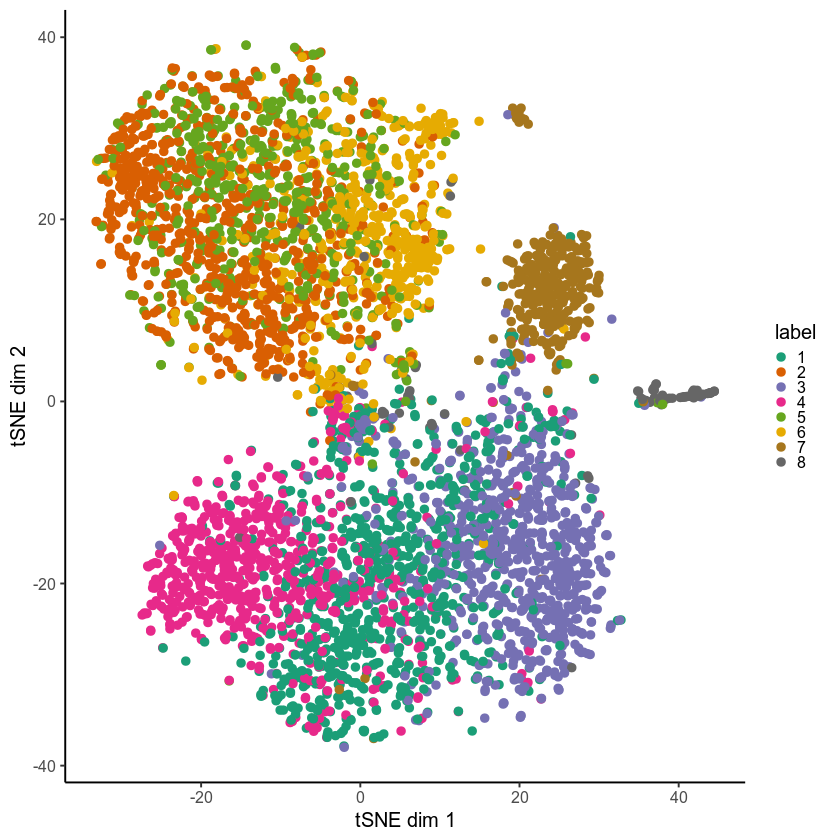

In [44]:
tsne_plots <- plotDeviationsTsne(dev, tsne_results, 
                                 sample_column = "label", 
                                 shiny = FALSE)
tsne_plots[[1]]

In [45]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_chromVAR/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg19_1.4.0 BSgenome_1.50.0                  
 [3] rtracklayer_1.42.1                Biostrings_2.50.2                
 [5] XVector_0.22.0                    JASPAR2016_1.10.0                
 [7] SummarizedExperiment_1.12.0 

In [46]:
save.image(file = 'ChromVAR_10xpbmc5k_kmers.RData')